<a href="https://colab.research.google.com/github/MinjuKim0217/Algorithm_Study/blob/master/fine_tuning_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# !pip install torchsummary

In [6]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

from torchsummary import summary

import os
import copy
import time
import numpy as np
import matplotlib.pyplot as plt

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.0.1+cu118
Torchvision Version:  0.15.2+cu118


## Prepair Dataset

In [7]:
!git clone https://github.com/folfcoder/recaptcha-dataset.git

fatal: destination path 'recaptcha-dataset' already exists and is not an empty directory.


In [8]:
!rm -rf ./recaptcha-dataset/Large/Mountain/
!rm -rf ./recaptcha-dataset/Large/Other/
!rm -rf ./recaptcha-dataset/Large/readme.txt

ImageFolder structure

```
data_dir/Bicycle/xxx.png
data_dir/Bicycle/xxy.png
data_dir/Bicycle/[...]/xxz.png
...
data_dir/Traffic Light/123.png
data_dir/Traffic Light/nsdf3.png
data_dir/Traffic Light/[...]/asd932_.png
```



In [9]:
data_dir = "./recaptcha-dataset/Large"
class_names = ['Bicycle', 'Bridge', 'Bus', 'Car', 
               'Chimney', 'Crosswalk', 'Hydrant', 
               'Motorcycle', 'Palm', 'Traffic Light']

input_size = 224
batch_size = 32

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = transforms.Compose([
        transforms.ToTensor(), # 0-1 사이로 정규화 
        transforms.RandomResizedCrop(input_size), # 정방형 크롭
        transforms.RandomHorizontalFlip(), # 좌우 반전 , data augmentation
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 이미지넷에서 평균적인 rgb값과 분산값 
    ])

print("Initializing Datasets and Dataloaders...")

image_datasets = datasets.ImageFolder(data_dir, data_transforms)  # your dataset
num_data = len(image_datasets) #인덱스 셔플 위해서
indices = np.arange(num_data)
np.random.shuffle(indices)

train_size = int(num_data*0.8) #80퍼의 데이터만 트레이닝 
train_indices = indices[:train_size]
val_indices = indices[train_size:] #20퍼 데이터 validation 
train_set = torch.utils.data.Subset(image_datasets, train_indices)
val_set = torch.utils.data.Subset(image_datasets, val_indices)

print('Number of training data:', len(train_set))
print('Number of validation data:', len(val_set))

dataloaders = {'train': torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4), # 얼마나 빨리 데이터 뽑을지 
                 'val': torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=4)}

                 # train set과 val set data loading하는 과정 

Initializing Datasets and Dataloaders...
Number of training data: 8233
Number of validation data: 2059


In [10]:
def imshow(imgs, title=None): #시각화 하는 함수
    """Display image for Tensor."""
    imgs = imgs.numpy().transpose((1, 2, 0)) # 차원을 바꿔준다. 길이 너비 차원 순
    mean = np.array([0.485, 0.456, 0.406]) #정규화 된 데이터
    std = np.array([0.229, 0.224, 0.225]) 
    imgs = std * imgs + mean # 정규화 풀어주기 
    imgs = np.clip(imgs, 0, 1)
    plt.imshow(imgs)
    if title is not None:
        plt.title(title)

inputs.shape: torch.Size([32, 3, 224, 224])
labels.shape: torch.Size([32])


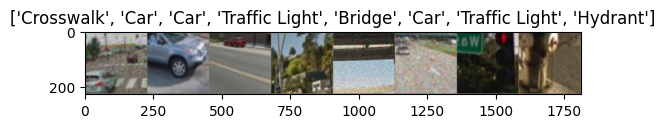

In [11]:
# Get a batch of training data
inputs, labels = next(iter(dataloaders['train']))
print("inputs.shape:", inputs.shape)
print("labels.shape:", labels.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:8])

imshow(out, title=[class_names[x] for x in labels[:8]])

inputs.shape: torch.Size([32, 3, 224, 224])
labels.shape: torch.Size([32])


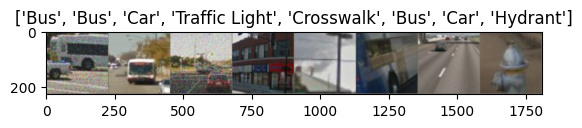

In [12]:
# Get a batch of validation data
inputs, labels = next(iter(dataloaders['val']))
print("inputs.shape:", inputs.shape)
print("labels.shape:", labels.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:8])

imshow(out, title=[class_names[x] for x in labels[:8]])

## Build model

### ResNet from scratch

![resnet](https://pytorch.org/assets/images/resnet.png)

In [13]:
class Block(nn.Module):
    
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1): # (self, 64, 128 ...)
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:  # downsampling 실행 
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x

In [14]:
class ResNet_18(nn.Module): # 4개의 함수 
    
    def __init__(self, image_channels, num_classes): # 열개의 클래스 존재 
        
        super(ResNet_18, self).__init__()
        self.in_channels = 64 # 첫번쨰 채널의 인풋이 64가 된다. 
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False) #112x112
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) #출력 사이즈 56ㅌ56
        
        #resnet layers
        self.layer1 = self.__make_layer(64, 64, stride=1) # 반복적으로 convolutoin 만들 수 있다. 
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def __make_layer(self, in_channels, out_channels, stride): #블록을 2번 반복하는 것이 하나의 레이어가 된다. 
        
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
            
        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride), 
            Block(out_channels, out_channels) # 그냥 간단하게 2번 블록을 만든다. 
        )
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x 
    
    def identity_downsample(self, in_channels, out_channels): 
        
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False), #2d로 downsampling , 이 연산은 하나의 값만 선택해서 convolution하는 연산 
            nn.BatchNorm2d(out_channels)
        )

In [15]:
model = ResNet_18(image_channels=3, num_classes=10) #rgb니깐 이미지 채널=3
summary(model, (3, 224, 224), device='cpu') # 모델을 넣게 되고 입력을 넣었을 때 파라미터가 몇개가 나오는지 출력해준다. 
# summary(model, (3, 512, 512), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
            Block-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

### Resnet from model zoo

In [16]:
def set_parameter_requires_grad(model, feature_extracting): # 특징 추출 용도면 feature_extractomg = true.
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [17]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True): # 영상 55분 부터 
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224
    
    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

  

In [24]:
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [27]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "densenet"

num_classes = 10
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
#summary(model_ft, (3, 224, 224), device='cpu')

## Train model

In [28]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    model = model.to(device)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                # 학습 단계 (loop)에서 최적화는 세단계로 이루어짐
                    ## optimizer.zero_grad()를 호출하여 모델 매개변수의 변화도를 재설정
                    ## 기본적으로 변화도는 더해지기 때문에 중복 계산을 막기 위해 반복할 때마다 명시적으로 재설정(0 할당)
                    ## loss.backwards()를 호출하여 prediction loss를 back-propagation함
                    ## 변화도를 계산한 뒤에는 optimizer.step()을 호출하여 수집된 변화도로 매개변수를 조정
                # gradients 파라미터를 0으로 초기화
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward() # update 가능 
                        optimizer.step() # 미분값 업데이트 

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since # 전체 시간에서 시작 시간을 뺴줘서 전체 실행 시간을 얻는다. 
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history # 가장 성능 좋은 모델 리턴

In [21]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [29]:
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name) 
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9) # 특징 추출에서만 쓰인다.

Params to learn:
	 features.conv0.weight
	 features.norm0.weight
	 features.norm0.bias
	 features.denseblock1.denselayer1.norm1.weight
	 features.denseblock1.denselayer1.norm1.bias
	 features.denseblock1.denselayer1.conv1.weight
	 features.denseblock1.denselayer1.norm2.weight
	 features.denseblock1.denselayer1.norm2.bias
	 features.denseblock1.denselayer1.conv2.weight
	 features.denseblock1.denselayer2.norm1.weight
	 features.denseblock1.denselayer2.norm1.bias
	 features.denseblock1.denselayer2.conv1.weight
	 features.denseblock1.denselayer2.norm2.weight
	 features.denseblock1.denselayer2.norm2.bias
	 features.denseblock1.denselayer2.conv2.weight
	 features.denseblock1.denselayer3.norm1.weight
	 features.denseblock1.denselayer3.norm1.bias
	 features.denseblock1.denselayer3.conv1.weight
	 features.denseblock1.denselayer3.norm2.weight
	 features.denseblock1.denselayer3.norm2.bias
	 features.denseblock1.denselayer3.conv2.weight
	 features.denseblock1.denselayer4.norm1.weight
	 features.de

In [30]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss() 

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 1.1005 Acc: 0.6456
val Loss: 0.6647 Acc: 0.7902

Epoch 1/14
----------
train Loss: 0.6613 Acc: 0.7897
val Loss: 0.5680 Acc: 0.8062

Epoch 2/14
----------
train Loss: 0.5836 Acc: 0.8086
val Loss: 0.5475 Acc: 0.8193

Epoch 3/14
----------
train Loss: 0.5437 Acc: 0.8232
val Loss: 0.4997 Acc: 0.8266

Epoch 4/14
----------
train Loss: 0.5029 Acc: 0.8336
val Loss: 0.5175 Acc: 0.8227

Epoch 5/14
----------
train Loss: 0.4647 Acc: 0.8453
val Loss: 0.5307 Acc: 0.8218

Epoch 6/14
----------
train Loss: 0.4540 Acc: 0.8495
val Loss: 0.4909 Acc: 0.8320

Epoch 7/14
----------
train Loss: 0.4522 Acc: 0.8508
val Loss: 0.4735 Acc: 0.8397

Epoch 8/14
----------
train Loss: 0.4336 Acc: 0.8573
val Loss: 0.4737 Acc: 0.8441

Epoch 9/14
----------
train Loss: 0.4284 Acc: 0.8629
val Loss: 0.4956 Acc: 0.8363

Epoch 10/14
----------
train Loss: 0.4094 Acc: 0.8637
val Loss: 0.4661 Acc: 0.8548

Epoch 11/14
----------
train Loss: 0.3982 Acc: 0.8709
val Loss: 0.4719 Acc: 0.8451

Ep

## Save the model & features

In [31]:
# torch.save(model_ft.state_dict(), 'resnet18.pt')

In [32]:
torch.save(model_ft, 'resnet18_ft.pt') # weight 값만 저장하겠다. 

In [33]:
model_ft = torch.load('resnet18_ft.pt') # 모델과 파라미터 다 여기에 저장해둔다.
modules = list(model_ft.children())[:-1]
resnet18_feat = nn.Sequential(*modules)
for p in resnet18_feat.parameters():
    p.requires_grad = False # 미분값 저장하지 않겠다. 

for inputs, labels in dataloaders['val']:
    inputs = inputs.to(device)
    h = resnet18_feat(inputs)
    # print(h.shape)      # [32, 512, 1, 1]

    '''
    code:
    save the (features, labels)
    '''